## Exercise
We will be working with the same dataset and questions we dealt with in the previous lab, so that you have some reference to work on (and check if your results match).

We will use the [Adult UCI dataset](https://archive.ics.uci.edu/ml/datasets/adult) with a few modifications; download the following files: [description](./files/adults/adults.names), [data - part1](./files/adults/adults1.csv) [data - part2](./files/adults/adults2.csv).

Follow the instructions below and answer the questions. 

Filtering and joins should be done in DAX, not in the UI. You should submit the PowerBI file plus a Jupyter Notebook including the DAX code for each question and a snapshot of the visualization. 

1-2 are the same instructions you followed for the Postgres lab, they are reproduced here for your convenience.

1. Create the two tables in the DB with the right data dypes. In order to use enumerated types in the table definition you will first need to create the type. For example:

```
CREATE TYPE mood AS ENUM ('sad', 'ok', 'happy');
CREATE TABLE person (
    name text,
    current_mood mood
);
INSERT INTO person VALUES ('Moe', 'happy');
SELECT * FROM person WHERE current_mood = 'happy';
 name | current_mood 
------+--------------
 Moe  | happy
```

Notice that each row/sample does not have an id. Instead of using an INTEGER data type for the id, we recommend you look into SERIAL.

2. Load the datasets. We should use this version of the copy_from command where we specify the name of the columns and the value for NULL in the file of origin. Notice how we are not specifying the id column, since that will be autogenerated by the DB. Caveat: once you have loaded the data, double check that the id/SERIAL column starts at 1. 
```
cursor.copy_from(f, 'adults1', columns=('age', 'workclass', ...), sep=',', null='?')
```
3. How many people under 18 years old have never worked? Of the never having worked people (all ages) is there any race bias (how many by race)? Is there any sex bias?
4. Look at the hours per week of people with a paying job, by sex. Look at how many's income is above and below 50k. Compare and analyse.
5. How many people with college education do manual labour?
6. What is the minimum, mean and maximum capital gain and capital loss for every marital status?

## 1. Create the two tables in the DB with the right data dypes. 

First we are going to connect to our database. Then thanks to lab 1 we already know what the two databases are and what types should be each elements so we just have to create the two tables with the right types. But we also need to give an id to each table.

In [6]:
import psycopg2


try:
    conn = psycopg2.connect("dbname='postgres' user='postgres' host='localhost' password='pass1234'")
    print('Success connecting to the DB')
    cursor = conn.cursor()
except:
    print('I am unable to connect to the database')


Success connecting to the DB


In [7]:
try:
    cursor.execute("""  CREATE TYPE workclass_type AS ENUM ('Private', 'Self-emp-not-inc', 'Self-emp-inc', 'Federal-gov', 'Local-gov', 'State-gov', 'Without-pay', 'Never-worked');
                        CREATE TYPE education_type as ENUM('Bachelors', 'Some-college', '11th', 'HS-grad', 'Prof-school', 'Assoc-acdm', 'Assoc-voc', '9th', '7th-8th', '12th', 'Masters', '1st-4th', '10th', 'Doctorate', '5th-6th', 'Preschool');
                        CREATE TYPE "marital-status_type" as ENUM('Married-civ-spouse', 'Divorced', 'Never-married', 'Separated', 'Widowed', 'Married-spouse-absent', 'Married-AF-spouse');
                        CREATE TYPE occupation_type as ENUM('Tech-support', 'Craft-repair', 'Other-service', 'Sales', 'Exec-managerial', 'Prof-specialty', 'Handlers-cleaners', 'Machine-op-inspct', 'Adm-clerical', 'Farming-fishing', 'Transport-moving', 'Priv-house-serv', 'Protective-serv', 'Armed-Forces');
                        CREATE TABLE adults1 (
                            id SERIAL PRIMARY KEY,
                            age smallint,
                            workclass workclass_type,
                            fnlwgt bigint,
                            education education_type,
                            "education-num" bigint,
                            "marital-status" "marital-status_type",
                            occupation occupation_type
                        );
                        """)
    
    cursor.execute("""  CREATE TYPE relationship_type AS ENUM ('Wife', 'Own-child', 'Husband', 'Not-in-family', 'Other-relative', 'Unmarried');
                        CREATE TYPE race_type as ENUM('White', 'Asian-Pac-Islander', 'Amer-Indian-Eskimo', 'Other', 'Black');
                        CREATE TYPE sex_type as ENUM('Female', 'Male');
                        CREATE TYPE "native-country_type" as ENUM('United-States', 'Cambodia', 'England', 'Puerto-Rico', 'Canada', 'Germany', 'Outlying-US(Guam-USVI-etc)', 'India', 'Japan', 'Greece', 'South', 'China', 'Cuba', 'Iran', 'Honduras', 'Philippines', 'Italy', 'Poland', 'Jamaica', 'Vietnam', 'Mexico', 'Portugal', 'Ireland', 'France', 'Dominican-Republic', 'Laos', 'Ecuador', 'Taiwan', 'Haiti', 'Columbia', 'Hungary', 'Guatemala', 'Nicaragua', 'Scotland', 'Thailand', 'Yugoslavia', 'El-Salvador', 'Trinadad&Tobago', 'Peru', 'Hong', 'Holand-Netherlands');
                        CREATE TYPE income_type as ENUM('>50K', '<=50K');
                        CREATE TABLE adults2 (
                            id SERIAL PRIMARY KEY,
                            relationship relationship_type,
                            race race_type,
                            sex sex_type,
                            "capital-gain" bigint,
                            "capital-loss" bigint,
                            "hours-per-week" smallint,
                            "native-country" "native-country_type",
                            income income_type
                        );
                        """)
    
    conn.commit()
except Exception as e:
    # if the transaction aborts we will need to rollback
    cursor.execute("ROLLBACK")
    print(e)

## 2. Load the datasets. Once you have loaded the data, double check that the id/SERIAL column starts at 1. 

We simply need to open each adults.csv file and load their data in the adults table.

In [8]:
try:
    with open('./files/adults/adults1.csv', 'r') as f:
        cursor.copy_from(f, 'adults1', columns=('age','workclass','fnlwgt','education','education-num','marital-status','occupation'), sep=',', null='?')
        
    with open('./files/adults/adults2.csv', 'r') as g:
        cursor.copy_from(g, 'adults2', columns=('relationship','race','sex','capital-gain','capital-loss','hours-per-week','native-country','income'), sep=',', null='?')
        
    conn.commit()
except Exception as e:
    # if the transaction aborts we will need to rollback
    cursor.execute("ROLLBACK")
    print(e)

Now let's check the serial column. Let's start by getting the serial sequence.

In [9]:
try:    
    cursor.execute("""  SELECT pg_get_serial_sequence('adults1', 'id'), pg_get_serial_sequence('adults2', 'id');""")
    rows = cursor.fetchall()
    print(rows)
except Exception as e:
    # if the transaction aborts we will need to rollback
    cursor.execute("ROLLBACK")
    print(e)

[('public.adults1_id_seq', 'public.adults2_id_seq')]


Once we have the sequence we can check the first value 

In [10]:
try:
    cursor.execute("""  SELECT start_value FROM pg_sequences WHERE schemaname = 'public' AND sequencename IN ('adults1_id_seq','adults2_id_seq');""")
    rows = cursor.fetchall()
    print(rows)
except Exception as e:
    # if the transaction aborts we will need to rollback
    cursor.execute("ROLLBACK")
    print(e)

[(1,), (1,)]


## 3. How many people under 18 years old have never worked? Of the never having worked people (all ages) is there any race bias (how many by race)? Is there any sex bias? - Note: no need to elaborate, just present the data in tables. 

First we count how many people under 18 years old have never worked with the following DAX code :

Table 1 = SUMMARIZE(FILTER(
    'public adults1'
    , 'public adults1'[age] < 18 && [workclass] = "Never-worked"),"People under 18 who have never worked", COUNT('public adults1'[age]))

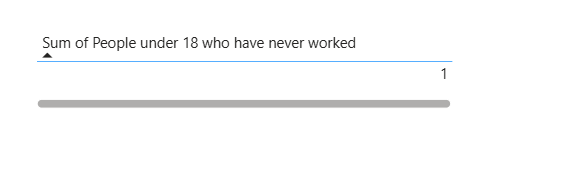

There is only one person under 18 who has never worked

Table 2 = SUMMARIZE(FILTER(NATURALLEFTOUTERJOIN( 'public adults1','public adults2')
    , 'public adults1'[workclass] = "Never-worked"),'public adults2'[race],"People who have never worked by race", COUNT('public adults1'[workclass]))

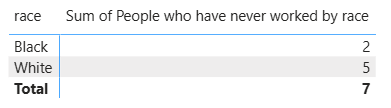

Table 3 = SUMMARIZE(NATURALLEFTOUTERJOIN( 'public adults1','public adults2')
    ,'public adults2'[race],"People by race", COUNT('public adults2'[race]))

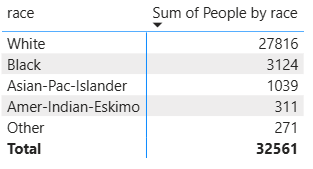

In the never worked group, the ratio of whites to blacks is 2.5, whereas in the general dataset whites are over-represented 8.9x. Now, these numbers are small and cannot confirm the bias, however, it is a hint that warrants further investigation (although by looking at different datasets).

Table 4 = SUMMARIZE(FILTER(NATURALLEFTOUTERJOIN( 'public adults1','public adults2')
    , 'public adults1'[workclass] = "Never-worked"),'public adults2'[sex],"People who have never worked by sex", COUNT('public adults1'[workclass]))

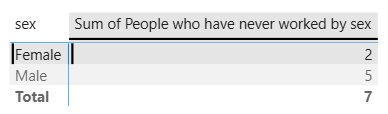

Table 5 = SUMMARIZE(NATURALLEFTOUTERJOIN( 'public adults1','public adults2')
    ,'public adults2'[sex],"People by sex", COUNT('public adults2'[sex]))

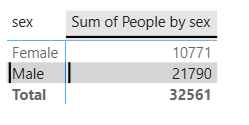

We cannot conclude there is sex bias, since the proportions are similar and most importantly, the number of samples is too small.

## 4. Look at the hours per week of people with a paying job, by sex. Look at how many's income is above and below 50k. Compare and analyse.